In [1]:
import os
import sys

import math
from datetime import timezone, datetime

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

In [2]:
#sys.path.append("../utils")
#import timescaledbutil
#
## PostgreSQL設定
#pg_config = {
#    'user': os.environ['POSTGRES_USER'],
#    'password': os.environ['POSTGRES_PASSWORD'],
#    'host': os.environ['POSTGRES_HOST'],
#    'port': os.environ['POSTGRES_PORT'],
#    'database': os.environ['POSTGRES_DATABASE']
#}

## PostgreSQLに接続する
## PostgreSQLテーブル作成などもあわせて行う
#dbutil = timescaledbutil.TimeScaleDBUtil(user = pg_config['user'], password = pg_config['password'], host = pg_config['host'], port = pg_config['port'], database = pg_config['database'])
#
#dbutil.init_time_table(symbol = "BTC-PERP", debug = False)
#dbutil.init_dollar_table(symbol = "BTC-PERP", debug = False)

In [3]:
#df_dollar = dbutil.read_sql_query(sql = "SELECT * FROM btc_perp_dollar_10m", index = 'time_bucket', debug = False)
#df_dollar = df_dollar[df_dollar['time_from'] > datetime(2021, 1, 1, 0, 0, 0, tzinfo=timezone.utc)]
#df_dollar.drop(['time_from', 'time_to', 'id_from', 'id_to'], axis = 1, inplace = True)
#df_dollar.to_pickle('df_dollar_10m_ohlcvl.pkl')
#
#df_time = dbutil.read_sql_query(sql = "SELECT * FROM btc_perp_time_10min", index = 'time_bucket', debug = False)
#df_time = df_time[df_time['time_from'] > datetime(2021, 1, 1, 0, 0, 0, tzinfo=timezone.utc)]
#df_time.drop(['time_from', 'time_to', 'id_from', 'id_to'], axis = 1, inplace = True)
#df_time.to_pickle('df_time_10min_ohlcvl.pkl')

In [4]:
df_dollar = pd.read_pickle('df_dollar_10m_ohlcvl.pkl')
df_dollar['fee'] = 0.0
df_dollar.to_pickle('df_dollar_10m_ohlcvl_fee.pkl')

df_time = pd.read_pickle('df_time_10min_ohlcvl.pkl')
df_time['fee'] = 0.0
df_time.to_pickle('df_time_10min_ohlcvl_fee.pkl')

In [5]:
def calc_features(df):
    open = df['open']
    high = df['high']
    low = df['low']
    close = df['close']
    volume = df['volume']
    liquidation = df['liquidation_volume']
    
    orig_columns = df.columns

    hilo = (df['high'] + df['low']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    return df

df_dollar = pd.read_pickle('df_dollar_10m_ohlcvl_fee.pkl')
df_dollar = df_dollar.dropna()
df_dollar = calc_features(df_dollar)
df_dollar.to_pickle('df_dollar_10m_ohlcvl_fee_features.pkl')

df_time = pd.read_pickle('df_time_10min_ohlcvl_fee.pkl')
df_time = df_time.dropna()
df_time = calc_features(df_time)
df_time.to_pickle('df_time_10min_ohlcvl_fee_features.pkl')

In [6]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])

print(features)

['ADX', 'ADXR', 'APO', 'AROONOSC', 'AROON_aroondown', 'AROON_aroonup', 'BBANDS_lowerband', 'BBANDS_middleband', 'BBANDS_upperband', 'BETA', 'CCI', 'DEMA', 'DX', 'EMA', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_TRENDLINE', 'HT_TRENDMODE', 'KAMA', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'MA', 'MACD_macd', 'MACD_macdhist', 'MACD_macdsignal', 'MFI', 'MIDPOINT', 'MOM', 'RSI', 'STDDEV', 'STOCHF_fastk', 'STOCH_slowd', 'STOCH_slowk', 'T3', 'TEMA', 'TRIMA', 'ULTOSC', 'WILLR', 'WMA']


In [7]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

In [8]:
def calc_buysell(df, pips = 1):
    # ATRで指値距離を計算します
    df['ATR'] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14)
    limit_price_dist = df['ATR'] * 0.5
    limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips
    
    # 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
    df['buy_price'] = df['close'] - limit_price_dist
    df['sell_price'] = df['close'] + limit_price_dist
    
    # Force Entry Priceの計算
    df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
        entry_price=df['buy_price'].values,
        lo=df['low'].values,
        pips=pips,
    )

    # calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
    df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
        entry_price=-df['sell_price'].values,
        lo=-df['high'].values, # 売りのときは高値
        pips=pips,
    )
    df['sell_fep'] *= -1
    
    horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
    fee = df['fee'] # maker手数料
    
    # 指値が約定したかどうか (0, 1)
    df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['low'].shift(-1) / pips).round()).astype('float64')
    df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['high'].shift(-1) / pips).round()).astype('float64')
    
    # yを計算
    df['y_buy'] = np.where(
        df['buy_executed'],
        df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
        0
    )
    df['y_sell'] = np.where(
        df['sell_executed'],
        -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
        0
    )

    # バックテストで利用する取引コストを計算
    df['buy_cost'] = np.where(
        df['buy_executed'],
        df['buy_price'] / df['close'] - 1 + fee,
        0
    )
    df['sell_cost'] = np.where(
        df['sell_executed'],
        -(df['sell_price'] / df['close'] - 1) + fee,
        0
    )
    
    return df

In [9]:
df_dollar = pd.read_pickle('df_dollar_10m_ohlcvl_fee_features.pkl')
df_dollar = calc_buysell(df_dollar, pips = 1)
df_dollar.to_pickle('df_dollar_10m_ohlcvl_fee_features_y.pkl')

df_time = pd.read_pickle('df_time_10min_ohlcvl_fee_features.pkl')
df_time = calc_buysell(df_time, pips = 1)
df_time.to_pickle('df_time_10min_ohlcvl_fee_features_y.pkl')

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


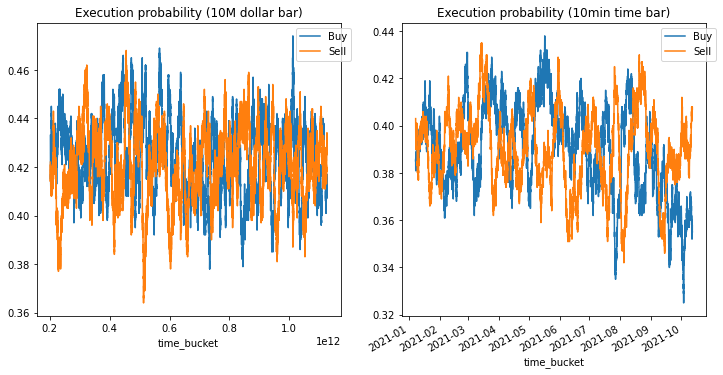

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


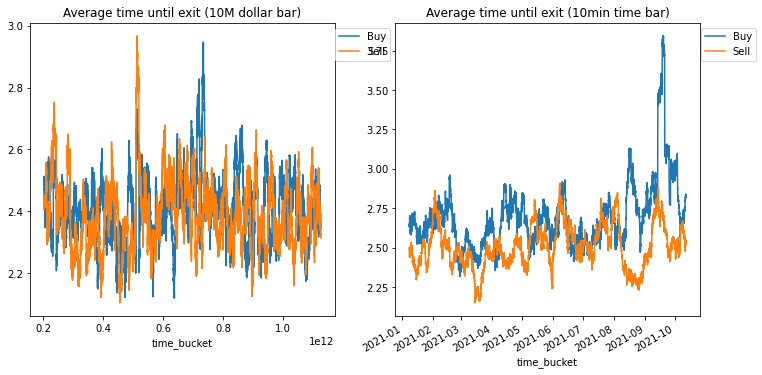

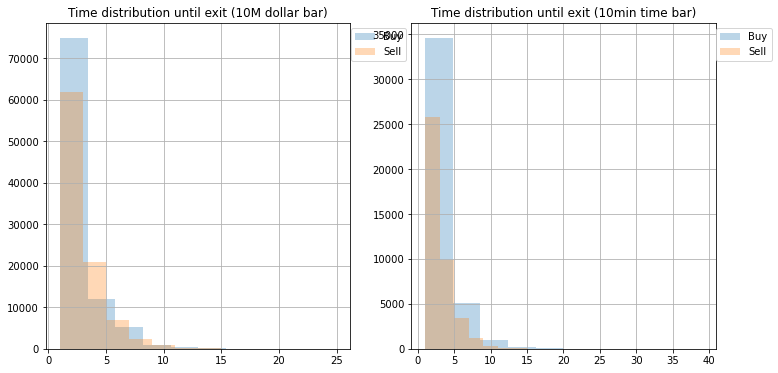

毎時刻、この執行方法でトレードした場合の累積リターン


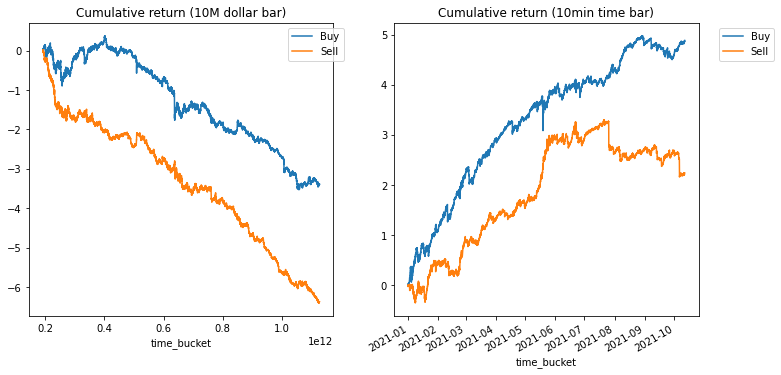

In [10]:
print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
plt.figure(figsize=(12,6))
ax = plt.subplot(121)
df_dollar['buy_executed'].rolling(1000).mean().plot(label='Buy', ax=ax)
df_dollar['sell_executed'].rolling(1000).mean().plot(label='Sell', ax=ax)
plt.title('Execution probability (10M dollar bar)')
plt.legend(bbox_to_anchor=(1.05, 1))

ax = plt.subplot(122)
df_time['buy_executed'].rolling(1000).mean().plot(label='Buy', ax=ax)
df_time['sell_executed'].rolling(1000).mean().plot(label='Sell', ax=ax)
plt.title('Execution probability (10min time bar)')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
plt.figure(figsize=(12,6))
ax = plt.subplot(121)
df_dollar['buy_fet'].rolling(1000).mean().plot(label='Buy')
df_dollar['sell_fet'].rolling(1000).mean().plot(label='Sell')
plt.title('Average time until exit (10M dollar bar)')
plt.legend(bbox_to_anchor=(1.2, 1))

ax = plt.subplot(122)
df_time['buy_fet'].rolling(1000).mean().plot(label='Buy')
df_time['sell_fet'].rolling(1000).mean().plot(label='Sell')
plt.title('Average time until exit (10min time bar)')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

plt.figure(figsize=(12,6))
ax = plt.subplot(121)
df_dollar['buy_fet'].hist(alpha=0.3, label='Buy')
df_dollar['sell_fet'].hist(alpha=0.3, label='Sell')
plt.title('Time distribution until exit (10M dollar bar)')
plt.legend(bbox_to_anchor=(1.2, 1))

ax = plt.subplot(122)
df_time['buy_fet'].hist(alpha=0.3, label='Buy')
df_time['sell_fet'].hist(alpha=0.3, label='Sell')
plt.title('Time distribution until exit (10min time bar)')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
plt.figure(figsize=(12,6))
ax = plt.subplot(121)
df_dollar['y_buy'].cumsum().plot(label='Buy')
df_dollar['y_sell'].cumsum().plot(label='Sell')
plt.title('Cumulative return (10M dollar bar)')
plt.legend(bbox_to_anchor=(1.05, 1))

ax = plt.subplot(122)
df_time['y_buy'].cumsum().plot(label='Buy')
df_time['y_sell'].cumsum().plot(label='Sell')
plt.title('Cumulative return (10min time bar)')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()


In [11]:
# OOS予測値を計算
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

def fit_and_predict(df, features = []):
    # モデル (コメントアウトで他モデルも試してみてください)
    # model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
    model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)

    # アンサンブル (コメントアウトを外して性能を比較してみてください)
    # model = BaggingRegressor(model, random_state=1, n_jobs=1)

    # 本番用モデルの学習 (このチュートリアルでは使わない)
    # 実稼働する用のモデルはデータ全体で学習させると良い
    model.fit(df[features], df['y_buy'])
    joblib.dump(model, 'model_y_buy.xz', compress=True) 
    model.fit(df[features], df['y_sell'])
    joblib.dump(model, 'model_y_sell.xz', compress=True)

    # 通常のCV
    cv_indicies = list(KFold().split(df))
    # ウォークフォワード法
    # cv_indicies = list(TimeSeriesSplit().split(df))
    
    df['y_pred_buy'] = my_cross_val_predict(model, df[features].values, df['y_buy'].values, cv=cv_indicies)
    df['y_pred_sell'] = my_cross_val_predict(model, df[features].values, df['y_sell'].values, cv=cv_indicies)

    # 予測値が無い(nan)行をドロップ
    df = df.dropna()
    
    return df

In [12]:
df_dollar = pd.read_pickle('df_dollar_10m_ohlcvl_fee_features_y.pkl')
df_dollar = df_dollar.dropna()
df_dollar = fit_and_predict(df_dollar, features = features)
df_dollar.to_pickle('df_dollar_10m_ohlcvl_fee_features_y_predict.pkl')

df_time = pd.read_pickle('df_time_10min_ohlcvl_fee_features_y.pkl')
df_time = df_time.dropna()
df_time = fit_and_predict(df_time, features = features)
df_time.to_pickle('df_time_10min_ohlcvl_fee_features_y_predict.pkl')

毎時刻、y_predがプラスのときだけトレードした場合の累積リターン


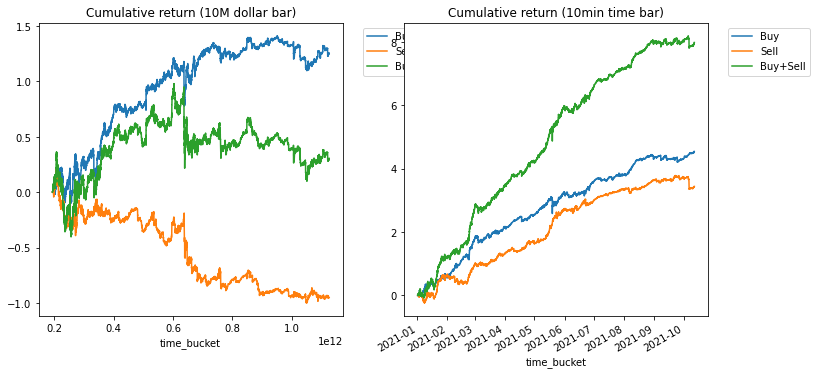

In [13]:
print('毎時刻、y_predがプラスのときだけトレードした場合の累積リターン')
plt.figure(figsize=(12,6))
ax = plt.subplot(121)
df_dollar[df_dollar['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='Buy')
df_dollar[df_dollar['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='Sell')
(df_dollar['y_buy'] * (df_dollar['y_pred_buy'] > 0) + df_dollar['y_sell'] * (df_dollar['y_pred_sell'] > 0)).cumsum().plot(label='Buy+Sell')
plt.title('Cumulative return (10M dollar bar)')
plt.legend(bbox_to_anchor=(1.05, 1))

ax = plt.subplot(122)
df_time[df_time['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='Buy')
df_time[df_time['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='Sell')
(df_time['y_buy'] * (df_time['y_pred_buy'] > 0) + df_time['y_sell'] * (df_time['y_pred_sell'] > 0)).cumsum().plot(label='Buy+Sell')
plt.title('Cumulative return (10min time bar)')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [14]:
@numba.njit
def backtest(cl=None, hi=None, lo=None, pips=None,
              buy_entry=None, sell_entry=None,
              buy_cost=None, sell_cost=None
            ):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos
        
        # exit
        if buy_cost[i]:
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] and buy_cost[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * buy_entry[i]
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * sell_entry[i]
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos
        
    return y, poss

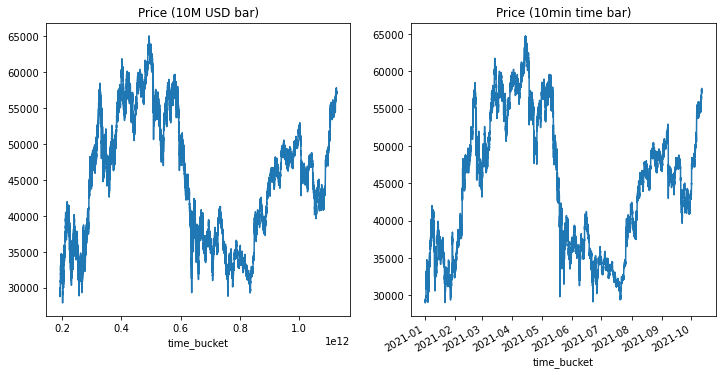

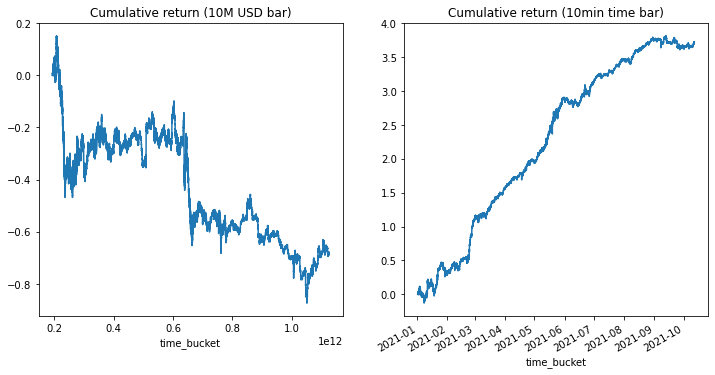

ポジション推移です。変動が細かすぎて青色一色になっていると思います。
ちゃんと全ての期間でトレードが発生しているので、正常です。


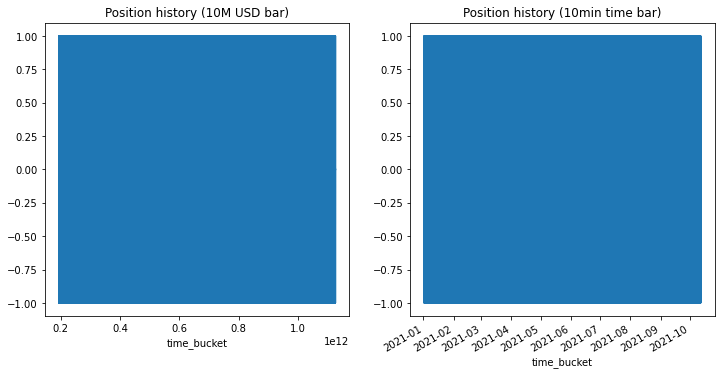

ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。


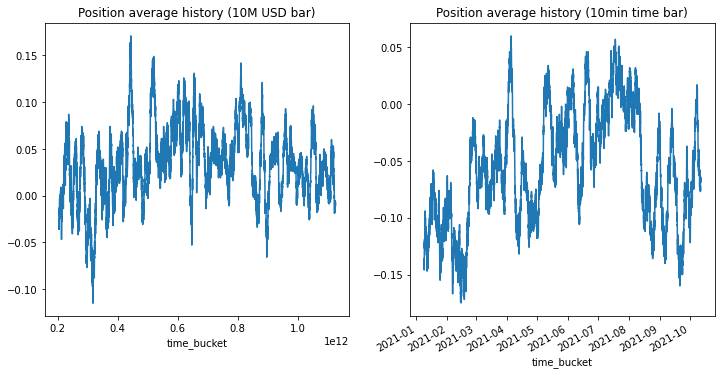

取引量(ポジション差分の絶対値)の累積です。
期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。


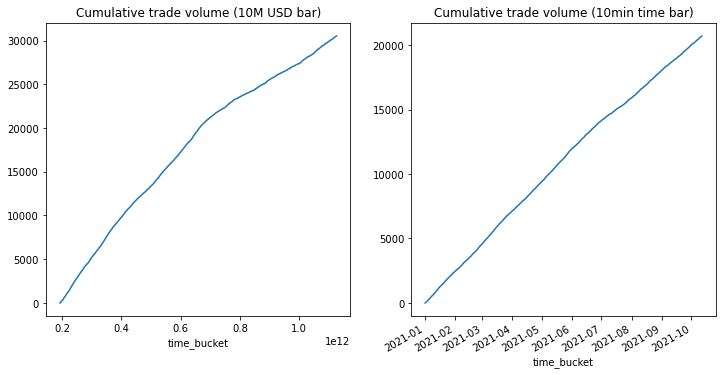

In [15]:
df_dollar = pd.read_pickle('df_dollar_10m_ohlcvl_fee_features_y_predict.pkl')
df_time = pd.read_pickle('df_time_10min_ohlcvl_fee_features_y_predict.pkl')

# バックテストで累積リターンと、ポジションを計算
df_dollar['cum_ret'], df_dollar['poss'] = backtest(
    cl=df_dollar['close'].values,
    buy_entry=df_dollar['y_pred_buy'].values > 0,
    sell_entry=df_dollar['y_pred_sell'].values > 0,
    buy_cost=df_dollar['buy_cost'].values,
    sell_cost=df_dollar['sell_cost'].values,
)

df_time['cum_ret'], df_time['poss'] = backtest(
    cl=df_time['close'].values,
    buy_entry=df_time['y_pred_buy'].values > 0,
    sell_entry=df_time['y_pred_sell'].values > 0,
    buy_cost=df_time['buy_cost'].values,
    sell_cost=df_time['sell_cost'].values,
)

plt.figure(figsize=(12,6))
ax = plt.subplot(121)
df_dollar['close'].plot(ax = ax)
plt.title('Price (10M USD bar)')

ax = plt.subplot(122)
df_time['close'].plot(ax = ax)
plt.title('Price (10min time bar)')
plt.show()

plt.figure(figsize=(12,6))
ax = plt.subplot(121)
df_dollar['cum_ret'].plot(ax = ax)
plt.title('Cumulative return (10M USD bar)')

ax = plt.subplot(122)
df_time['cum_ret'].plot(ax = ax)
plt.title('Cumulative return (10min time bar)')
plt.show()

print('ポジション推移です。変動が細かすぎて青色一色になっていると思います。')
print('ちゃんと全ての期間でトレードが発生しているので、正常です。')
plt.figure(figsize=(12,6))
ax = plt.subplot(121)
df_dollar['poss'].plot()
plt.title('Position history (10M USD bar)')

ax = plt.subplot(122)
df_time['poss'].plot()
plt.title('Position history (10min time bar)')
plt.show()

print('ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。')
plt.figure(figsize=(12,6))
ax = plt.subplot(121)
df_dollar['poss'].rolling(1000).mean().plot()
plt.title('Position average history (10M USD bar)')

ax = plt.subplot(122)
df_time['poss'].rolling(1000).mean().plot()
plt.title('Position average history (10min time bar)')
plt.show()

print('取引量(ポジション差分の絶対値)の累積です。')
print('期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。')
plt.figure(figsize=(12,6))
ax = plt.subplot(121)
df_dollar['poss'].diff(1).abs().dropna().cumsum().plot()
plt.title('Cumulative trade volume (10M USD bar)')

ax = plt.subplot(122)
df_time['poss'].diff(1).abs().dropna().cumsum().plot()
plt.title('Cumulative trade volume (10min time bar)')
plt.show()

In [16]:
def tp_test(df):
    x = df['cum_ret'].diff(1).dropna()
    t, p = ttest_1samp(x, 0)
    print(f"t値 {t}, p値 {p}")

# p平均法 https://note.com/btcml/n/n0d9575882640
def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)

def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)

def p_mean_test(df):
    x = df['cum_ret'].diff(1).dropna()
    p_mean_n = 5
    p_mean = calc_p_mean(x, p_mean_n)
    print(f"p平均法 n = {p_mean_n} p平均 {p_mean} エラー率 {calc_p_mean_type1_error_rate(p_mean, p_mean_n)}")

In [17]:
print('t検定 (10M USD bar)')
tp_test(df_dollar)
print('p平均検定 (10M USD bar)')
p_mean_test(df_dollar)

print("\n")

print('t検定 (10min time bar)')
tp_test(df_time)
print('p平均検定 (10min time bar)')
p_mean_test(df_time)


t検定 (10M USD bar)
t値 -1.102296745667465, p値 0.27033552773289937
p平均検定 (10M USD bar)
p平均法 n = 5 p平均 0.9503017047755253 エラー率 20.182563028820375


t検定 (10min time bar)
t値 4.980749598673341, p値 6.359671363466404e-07
p平均検定 (10min time bar)
p平均法 n = 5 p平均 0.12471222742890305 エラー率 0.0007856225773762362
